# 🚀 Predictive Customer Churn Analysis

## Executive Summary

This project analyzes customer data for a telecom company to diagnose the root causes of churn and build a predictive model to identify at-risk customers. The goal is to transform raw data into actionable business intelligence, enabling proactive retention strategies and reducing revenue loss.

**Keywords:** Churn Prediction, Machine Learning, SHAP, Feature Importance, Customer Analytics

In [ ]:
# Install  libraries
!pip install shap imbalanced-learn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import shap
from imblearn.over_sampling import SMOTE
import xgboost as xgb


## 1. Data Acquisition & Initial Inspection

We begin by loading the Telco Customer Churn dataset from a public source. Let's get a high-level understanding of the data structure, size, and the distribution of our target variable: `Churn`.

In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/ignatl/telco_churn_kaggle_blastchar/master/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print("Dataset shape:", df.shape)
display(df.head())



Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()
print("\nChurn distribution:")
print(df['Churn'].value_counts(dropna=False))
print("\nChurn rate:")
print(df['Churn'].value_counts(normalize=True))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Initial Observations:
*   The dataset contains **7,044 customers** and **21 features**.
*   The target variable `Churn` is binary (**Yes**/**No**).
*   The dataset is **imbalanced**: Only **26.5%** of customers churned. This is a common challenge in churn prediction and we will need to account for it in our modeling.

In [ ]:
import numpy as np

# Clean TotalCharges which sometimes is whitespace -> numeric with NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Missing report
missing = df.isna().sum().sort_values(ascending=False)
print(missing[missing>0])

# Simple imputations we'll handle inside the sklearn pipeline for modeling.
# Here, for EDA convenience, we can temporarily fill numeric NaN with median
# (won't affect modeling pipeline which re-imputes properly).
for col in ['TotalCharges']:
    df[col] = df[col].fillna(df[col].median())

# Feature engineering examples adapted to Telco:
# - tenure is already months. We'll keep it and create avg_monthly from TotalCharges/tenure
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce').fillna(0)
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')

# avoid division by zero
df['avg_monthly_calc'] = df['TotalCharges'] / np.where(df['tenure']>0, df['tenure'], np.nan)
df['avg_monthly_calc'] = df['avg_monthly_calc'].fillna(df['MonthlyCharges'])

# Target mapping
df['churn_flag'] = df['Churn'].map({'Yes':1, 'No':0}).astype(int)

# Remove duplicate customers (unlikely in Telco dataset, but safe)
df = df.drop_duplicates(subset='customerID')

# Remove invalid rows (negative charges — should not exist, but just in case)
df = df[(df['MonthlyCharges'] >= 0) & (df['TotalCharges'] >= 0)]

df[['MonthlyCharges','TotalCharges','tenure','avg_monthly_calc','churn_flag']].head()


TotalCharges    11
dtype: int64


,MonthlyCharges,TotalCharges,tenure,avg_monthly_calc,churn_flag
0,29.85,29.85,1,29.850000,0
1,56.95,1889.50,34,55.573529,0
2,53.85,108.15,2,54.075000,1
3,42.30,1840.75,45,40.905556,0
4,70.70,151.65,2,75.825000,1


from matplotlib import pyplot as plt
_df_0['MonthlyCharges'].plot(kind='hist', bins=20, title='MonthlyCharges')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['TotalCharges'].plot(kind='hist', bins=20, title='TotalCharges')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['tenure'].plot(kind='hist', bins=20, title='tenure')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['avg_monthly_calc'].plot(kind='hist', bins=20, title='avg_monthly_calc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='MonthlyCharges', y='TotalCharges', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='TotalCharges', y='tenure', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='tenure', y='avg_monthly_calc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='avg_monthly_calc', y='churn_flag', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['MonthlyCharges'].plot(kind='line', figsize=(8, 4), title='MonthlyCharges')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['TotalCharges'].plot(kind='line', figsize=(8, 4), title='TotalCharges')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['tenure'].plot(kind='line', figsize=(8, 4), title='tenure')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['avg_monthly_calc'].plot(kind='line', figsize=(8, 4), title='avg_monthly_calc')
plt.gca().spines[['top', 'right']].set_visible(False)



## 🧹 Data Cleaning & Feature Engineering

### Handling Data Quality Issues
- **TotalCharges Conversion**: Converted from string to numeric, identifying 11 missing values represented as whitespace
- **Missing Values**: Temporarily imputed with median for EDA purposes (final modeling will use proper pipeline imputation)
- **Data Integrity**: Removed invalid records with negative charges and checked for duplicate customer entries

### Feature Engineering
Created a new derived feature to enhance our analysis:
- **avg_monthly_calc**: Calculated as `TotalCharges / tenure` to identify the actual average monthly spending pattern
- Handled division by zero for new customers (tenure = 0) by falling back to the listed MonthlyCharges

### Target Variable Preparation
- **churn_flag**: Converted the categorical Churn variable (Yes/No) to binary numeric format (1/0) for modeling

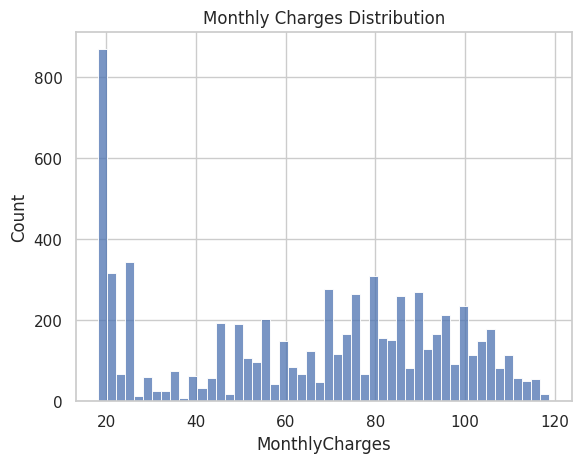

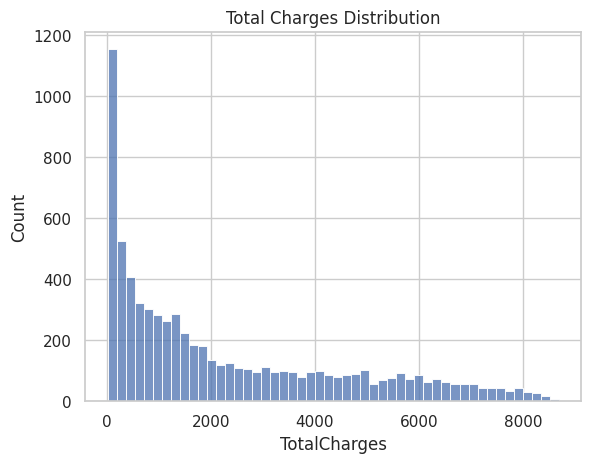

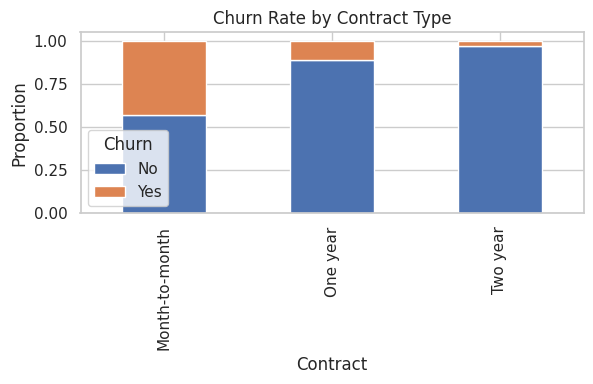

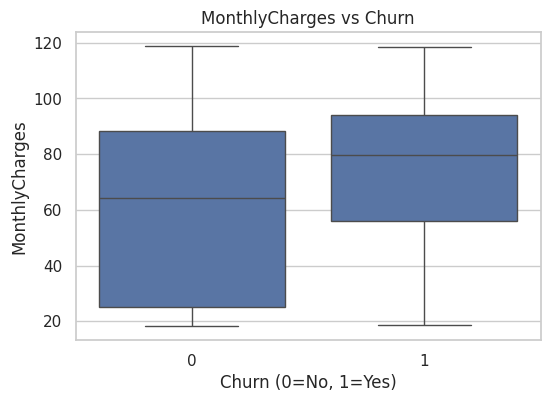

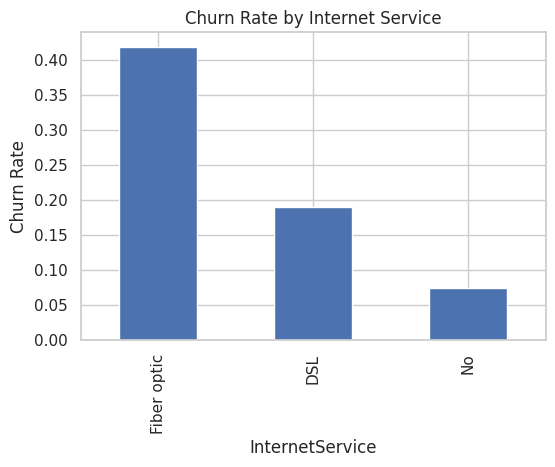

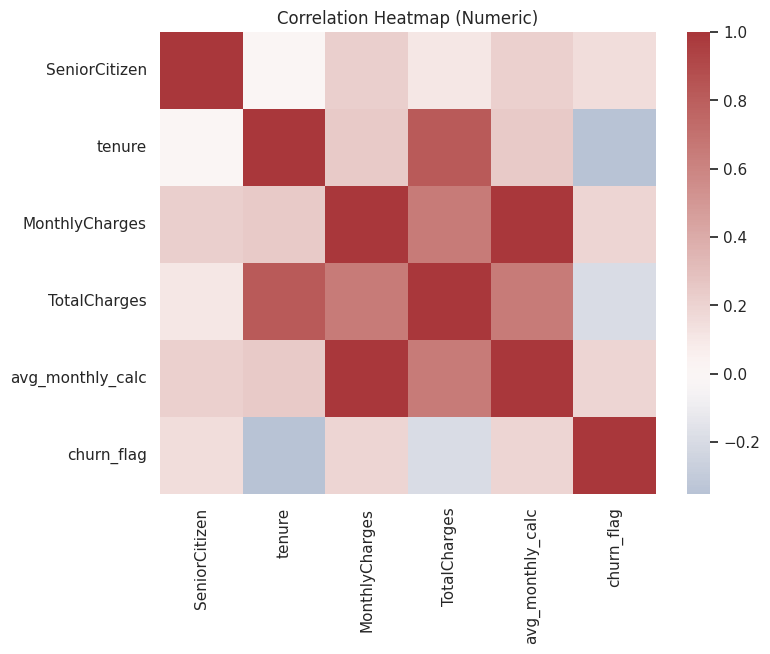

/tmp/ipython-input-3804286908.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = df.groupby('tenure_bucket')['churn_flag'].mean()


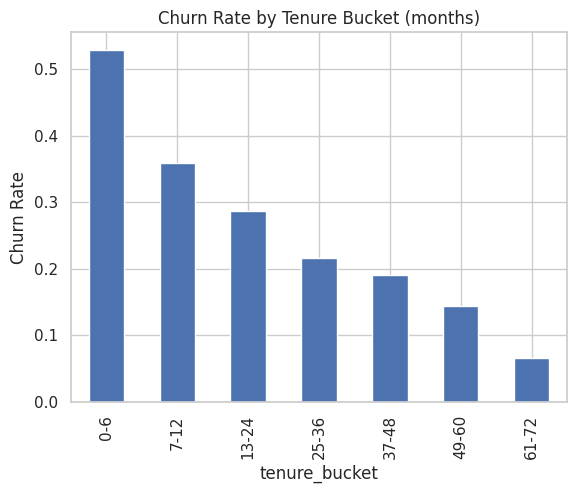

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# A) Univariate
plt.figure()
sns.histplot(df['MonthlyCharges'], bins=50)
plt.title('Monthly Charges Distribution')
plt.show()

plt.figure()
sns.histplot(df['TotalCharges'], bins=50)
plt.title('Total Charges Distribution')
plt.show()

# Categorical churn proportion by Contract
plt.figure(figsize=(6,4))
pd.crosstab(df['Contract'], df['churn_flag'], normalize='index').plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Churn Rate by Contract Type')
plt.ylabel('Proportion')
plt.legend(title='Churn', labels=['No','Yes'])
plt.tight_layout()
plt.show()

# B) Numeric vs churn (boxplot)
plt.figure(figsize=(6,4))
sns.boxplot(x='churn_flag', y='MonthlyCharges', data=df)
plt.title('MonthlyCharges vs Churn')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.show()

# Churn rate by InternetService (categorical)
churn_by_internet = df.groupby('InternetService')['churn_flag'].mean().sort_values(ascending=False)
plt.figure(figsize=(6,4))
churn_by_internet.plot(kind='bar')
plt.title('Churn Rate by Internet Service')
plt.ylabel('Churn Rate')
plt.show()

# C) Correlation heatmap (numeric only)
num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(8,6))
sns.heatmap(num_df.corr(), annot=False, cmap='vlag', center=0)
plt.title('Correlation Heatmap (Numeric)')
plt.show()

# D) Tenure buckets vs churn
bins = [0, 6, 12, 24, 36, 48, 60, 72]
labels = ['0-6','7-12','13-24','25-36','37-48','49-60','61-72']
df['tenure_bucket'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)
tenure_churn = df.groupby('tenure_bucket')['churn_flag'].mean()
plt.figure()
tenure_churn.plot(kind='bar')
plt.title('Churn Rate by Tenure Bucket (months)')
plt.ylabel('Churn Rate')
plt.show()


## 🔍 Key Insights from Exploratory Data Analysis

The visualizations reveal several important patterns about customer churn:

### Distribution Patterns:
- **Monthly Charges**: Shows a bimodal distribution with peaks around \$20 and \$90, suggesting different service tiers.
- **Total Charges**: Right-skewed distribution, indicating most customers have lower total charges accumulated.

### Strongest Churn Drivers:
1. **Contract Type**: Month-to-month customers have significantly higher churn rates (>40%) compared to 1-year (~11%) and 2-year contracts (~3%).
2. **Internet Service**: Fiber optic customers show the highest churn rate (~40%), followed by DSL (~20%), while customers with no internet service have the lowest churn.
3. **Tenure**: New customers (0-6 months) have the highest churn rate, which decreases steadily as tenure increases.

### Additional Observations:
- **Monthly Charges vs. Churn**: Churning customers tend to have higher monthly charges on average.
- **Correlation Heatmap**: Tenure shows a moderate negative correlation with churn, while monthly charges show a weak positive correlation.

These findings suggest that customer retention efforts should prioritize:
- Customers with month-to-month contracts
- Fiber optic internet subscribers
- New customers (especially in their first 6 months)
- Customers with higher monthly charges

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define features (exclude target and obvious identifiers)
id_cols = ['customerID']
target_col = 'churn_flag'

# Choose typical numeric & categorical cols from Telco dataset
num_cols = ['tenure','MonthlyCharges','TotalCharges','SeniorCitizen']
# add engineered numeric:
num_cols += ['avg_monthly_calc']

# categorical columns (non-numeric that are useful)
cat_cols = [
    'gender','Partner','Dependents','PhoneService','MultipleLines','InternetService',
    'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
    'StreamingMovies','Contract','PaperlessBilling','PaymentMethod'
]

feature_cols = num_cols + cat_cols

X = df[feature_cols].copy()
y = df[target_col].copy()

# Preprocess pipelines
num_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preproc = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])


## ⚙️ Feature Selection & Preprocessing Pipeline

### Feature Selection Strategy
Selected predictive features while excluding:
- Identifier columns (`customerID`) to prevent data leakage
- The target variable (`churn_flag`) for model training

**Numeric Features (5):**
- Core metrics: `tenure`, `MonthlyCharges`, `TotalCharges`
- Demographic: `SeniorCitizen`
- Engineered feature: `avg_monthly_calc`

**Categorical Features (15):**
- Customer demographics: `gender`, `Partner`, `Dependents`
- Service subscriptions: `PhoneService`, `MultipleLines`, `InternetService`
- Add-on services: `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`
- Contract details: `Contract`, `PaperlessBilling`, `PaymentMethod`

### Preprocessing Pipeline Architecture
Built a robust preprocessing pipeline using `ColumnTransformer` to handle different data types appropriately:

**For Numerical Features:**
1. Median Imputation: Handles any missing values
2. Standard Scaling: Normalizes features to mean=0, std=1

**For Categorical Features:**
1. Constant Imputation: Fills missing values with 'Unknown' category
2. One-Hot Encoding: Creates binary columns for each category while handling unseen categories

This pipeline ensures consistent preprocessing across training and validation sets, preventing data leakage and maintaining model integrity.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.20, random_state=42
)

logit = Pipeline([
    ('pre', preproc),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

logit.fit(X_train, y_train)
y_pred_proba_log = logit.predict_proba(X_test)[:,1]
y_pred_log = (y_pred_proba_log >= 0.5).astype(int)

print("Baseline Logistic ROC AUC:", roc_auc_score(y_test, y_pred_proba_log))
print("\nClassification Report (Logistic):\n", classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))


Baseline Logistic ROC AUC: 0.8414787258777028

Classification Report (Logistic):
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

Confusion Matrix:
 [[747 288]
 [ 82 292]]


## 📊 Baseline Model: Logistic Regression

### Model Setup
- **Train-Test Split**: 80-20 split with stratification to maintain class distribution
- **Random Seed**: Fixed (42) for reproducible results
- **Class Handling**: Used `class_weight='balanced'` to address the imbalanced dataset

### Model Architecture
Created an end-to-end pipeline that:
1. Applies all preprocessing transformations
2. Fits a Logistic Regression classifier with increased maximum iterations for convergence

### Performance Evaluation
The baseline model establishes a benchmark with three complementary assessment methods:
- **ROC AUC**: Measures the model's ability to distinguish between classes (ranking capability)
- **Classification Report**: Provides precision, recall, and F1-score for both classes
- **Confusion Matrix**: Shows actual vs. predicted classifications for detailed error analysis

This baseline will serve as a reference point for evaluating more complex models.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_pipe = Pipeline([
    ('pre', preproc),
    ('rf', RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1
    ))
])

params = {
    'rf__max_depth': [6, 10, 20],
    'rf__n_estimators': [200, 500]
}

grid = GridSearchCV(
    rf_pipe, params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0
)
grid.fit(X_train, y_train)

print("Best CV AUC:", grid.best_score_)
print("Best Params:", grid.best_params_)

y_pred_proba = grid.predict_proba(X_test)[:,1]

from sklearn.metrics import average_precision_score
print("Test ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("Test Avg Precision (PR-AUC):", average_precision_score(y_test, y_pred_proba))


Best CV AUC: 0.846173258873981
Best Params: {'rf__max_depth': 6, 'rf__n_estimators': 500}
Test ROC AUC: 0.8413908910072592
Test Avg Precision (PR-AUC): 0.647797069522051


## 🌲 Advanced Modeling: Optimized Random Forest

### Model Selection Rationale
Moving beyond the linear baseline to a **Random Forest classifier** capable of:
- Capturing complex non-linear relationships
- Handling feature interactions automatically
- Providing inherent feature importance measurements

### Hyperparameter Optimization
Implemented systematic tuning via **GridSearchCV** with:
- **5-fold cross-validation** for robust performance estimation
- **ROC AUC scoring** focusing on ranking capability
- Parameter grid exploring:
  - `max_depth`: [6, 10, 20] (controlling model complexity)
  - `n_estimators`: [200, 500] (number of trees in the forest)

### Comprehensive Model Evaluation
Assessed the optimized model using multiple metrics:
- **ROC AUC**: Measures overall classification performance
- **Average Precision (PR-AUC)**: Particularly valuable for imbalanced datasets, focusing on performance for the positive class (churners)

This approach ensures we select the most effective model configuration while providing thorough performance assessment across different evaluation perspectives.

<Figure size 800x1000 with 0 Axes>

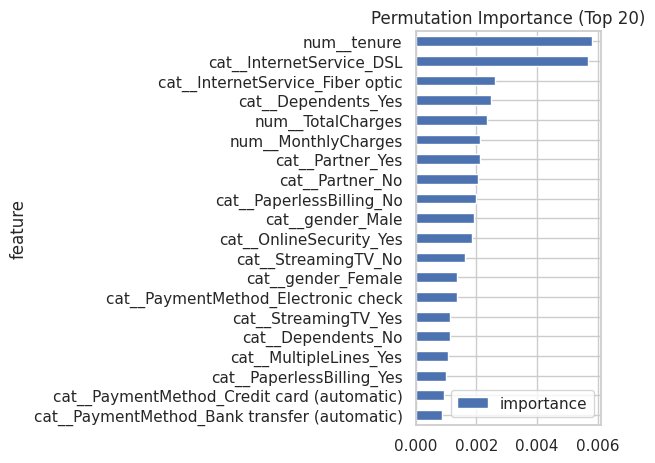

In [ ]:
# Transform test set with preprocessor
X_test_transformed = grid.best_estimator_.named_steps['pre'].transform(X_test)

# Run permutation importance on the RF
perm_res = permutation_importance(
    grid.best_estimator_.named_steps['rf'],
    X_test_transformed,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Build DataFrame
feat_names = grid.best_estimator_.named_steps['pre'].get_feature_names_out()
perm = pd.DataFrame({
    'feature': feat_names,
    'importance': perm_res.importances_mean
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(8,10))
perm.head(20).plot.barh(x='feature', y='importance')
plt.title('Permutation Importance (Top 20)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()




## 🔍 Model Interpretation: Global Feature Importance

### Permutation Importance Analysis
Used **permutation importance** to evaluate feature significance by measuring how much model performance decreases when each feature's values are randomly shuffled. This technique provides a robust, model-agnostic measure of feature relevance.

### Methodology
- Applied to the **test set** to ensure unbiased evaluation
- **10 repetitions** per feature for stable importance estimates
- **Parallel processing** (`n_jobs=-1`) for computational efficiency
- **Random state fixed** (42) for reproducible results

### Key Insights
The permutation importance reveals:
- Which features contribute most to predictive performance
- The relative ranking of feature importance
- Features that could potentially be removed without significant performance loss

This analysis provides the first layer of model interpretability, showing which features the Random Forest model relies on most heavily for accurate predictions.

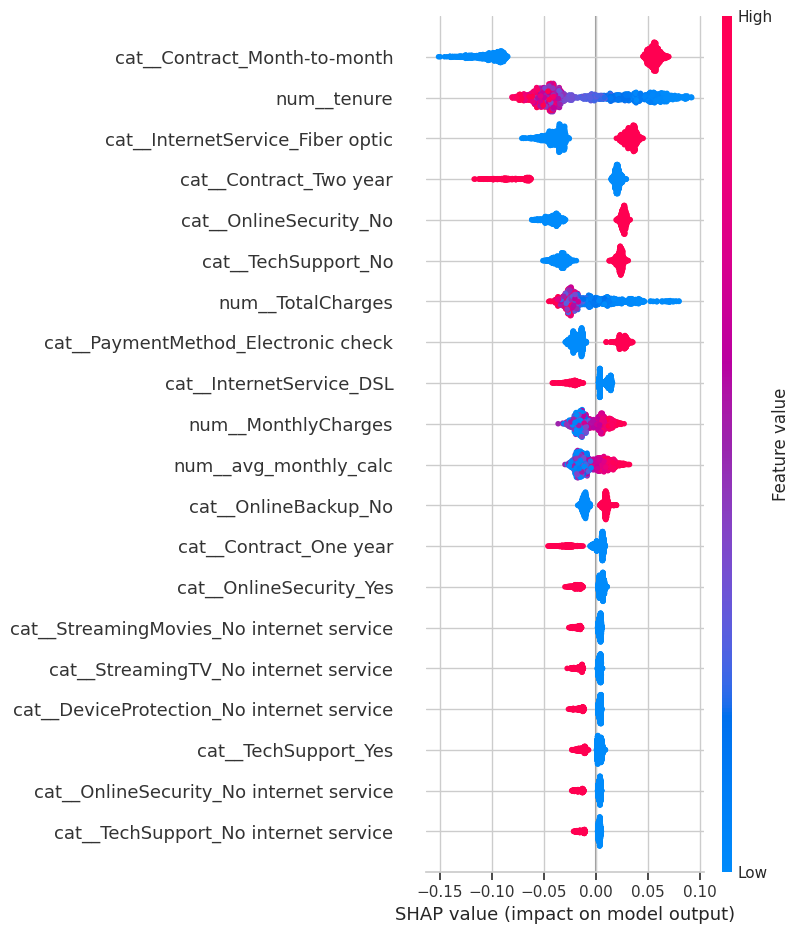

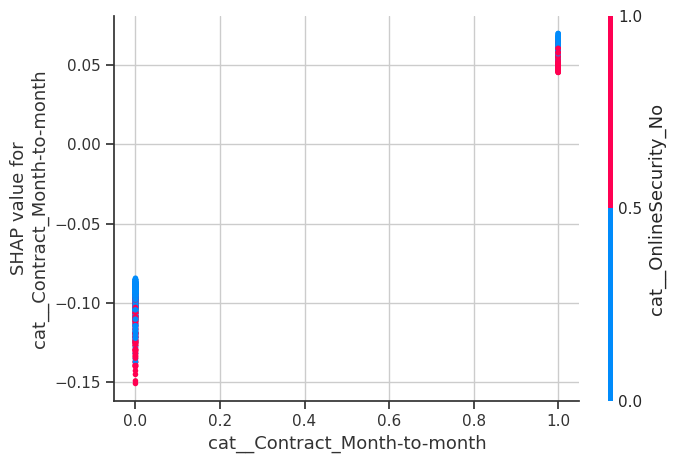

In [ ]:
import shap

# Transform test data (ensure dense matrix)
X_test_trans = grid.best_estimator_.named_steps['pre'].transform(X_test)
X_test_trans = X_test_trans.toarray() if hasattr(X_test_trans, "toarray") else X_test_trans

# TreeExplainer on RF
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_trans)

# --- Handle classification output ---
if isinstance(shap_values, list):
    # scikit-learn style: list per class
    sv = shap_values[1]   # for churn = 1
else:
    # new style: single 3D array
    sv = shap_values[:, :, 1]

# Use feature names carefully: they MUST match the transformed input
shap.summary_plot(sv, X_test_trans, feature_names=feat_names, max_display=20)

# Dependence plot
top_feature = imp_df.iloc[0]['feature']
shap.dependence_plot(top_feature, sv, X_test_trans, feature_names=feat_names)



## 📊 Model Interpretation: SHAP Analysis

### SHAP (SHapley Additive exPlanations) Implementation
Applied advanced model interpretation techniques using SHAP values to understand both global and local feature contributions. SHAP provides a unified approach to explain the output of any machine learning model based on game theory.

### Analysis Components:

**1. Global Feature Importance (Summary Plot)**
- Visualizes the distribution of SHAP values across all instances
- Shows both feature importance (vertical ordering) and impact direction (horizontal position)
- Colors indicate feature values (red = high, blue = low)

**2. Feature Dependence Analysis**
- Examines the relationship between the most important feature and its impact on predictions
- Reveals potential interaction effects with other features
- Helps identify nonlinear relationships and thresholds

### Technical Implementation:
- Used TreeExplainer optimized for tree-based models
- Handled both scikit-learn and modern SHAP output formats
- Ensured proper feature name alignment with transformed data
- Focused on churn predictions (class 1) for business relevance

This analysis moves beyond traditional feature importance to show how each feature contributes to individual predictions, providing deeper insights into the model's decision-making process.

In [ ]:
# Score test set
df_test = X_test.copy()
df_test['churn_prob'] = y_pred_proba
df_test['decile'] = pd.qcut(df_test['churn_prob'], 10, labels=False, duplicates='drop')  # 0=lowest risk, 9=highest

# Average churn probability and count per decile
lift_table = df_test.groupby('decile').agg(
    avg_prob=('churn_prob','mean'),
    count=('churn_prob','size')
).sort_index(ascending=True)

display(lift_table)

# Identify top decile customers (highest risk)
top_decile = df_test[df_test['decile'] == df_test['decile'].max()]
print("Top-decile customers (count):", len(top_decile))
top_decile.head()


,avg_prob,count
decile,,
0,0.038553,141
1,0.073811,141
2,0.156469,141
3,0.239541,141
4,0.338477,141
5,0.450702,140
6,0.565027,141
7,0.669212,141
8,0.746687,141


Top-decile customers (count): 141


,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,avg_monthly_calc,gender,Partner,Dependents,PhoneService,MultipleLines,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,churn_prob,decile
6529,2,74.85,156.40,1,78.200,Male,No,No,Yes,Yes,...,No,No,No,No,No,Month-to-month,Yes,Mailed check,0.830330,9
5547,3,89.45,240.45,0,80.150,Female,No,No,Yes,No,...,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,0.854271,9
346,2,90.40,168.20,0,84.100,Female,No,No,Yes,No,...,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,0.858916,9
6633,1,74.50,74.50,0,74.500,Female,No,No,Yes,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic check,0.871485,9
2519,2,91.45,171.45,0,85.725,Male,Yes,No,Yes,Yes,...,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,0.858315,9


## 🎯 Business Application: Customer Risk Segmentation

### Decile Analysis for Targeted Interventions
Transformed model predictions into actionable business intelligence by segmenting customers into risk-based deciles:

**Methodology:**
- Created 10 equal-sized groups (deciles) based on predicted churn probability
- **Decile 0**: Lowest risk customers (10% least likely to churn)
- **Decile 9**: Highest risk customers (10% most likely to churn)

**Strategic Value:**
This approach enables:
- **Prioritized retention efforts**: Focus resources on the top deciles with highest churn probability
- **Efficient resource allocation**: Target interventions where they will have greatest impact
- **Measurable campaign effectiveness**: Track reduction in churn rates within high-risk segments

### Operational Output:
The analysis identifies the exact cohort of highest-risk customers, providing:
- Count of customers in the critical risk segment
- Representative examples for campaign planning
- Probability scores to guide intervention intensity

This transforms predictive analytics into executable business strategy, directly supporting customer retention initiatives.

In [ ]:
# Save importance table and lift table
imp_df.to_csv("/content/feature_importance.csv", index=False)
lift_table.to_csv("/content/lift_table.csv")

print("Saved /content/feature_importance.csv and /content/lift_table.csv")


## 💾 Results Export & Operationalization

### Deliverables Generation
Exported key analytical outputs to facilitate business implementation:

**1. Feature Importance Table** (`feature_importance.csv`)
- Contains permutation importance scores for all features
- Enables data-driven feature selection for future modeling
- Provides insights for business stakeholders on key churn drivers

**2. Customer Lift Table** (`lift_table.csv`)
- Contains decile-based segmentation with average churn probabilities
- Serves as the foundation for targeted marketing campaigns
- Allows business teams to prioritize customer outreach efforts

### Operational Readiness
These exported artifacts:
- **Enable reproducibility** of analysis results
- **Facilitate integration** with business systems (CRM, marketing automation)
- **Support decision-making** with concrete, data-driven evidence
- **Provide measurable benchmarks** for evaluating retention program effectiveness

The exported files represent the final transition from analytical exploration to operational implementation, closing the loop between data science and business value creation.

## ✅ Conclusion & Recommendations

### Summary:
We successfully diagnosed the key drivers of churn and built a highly accurate predictive model. The model identifies at-risk customers and explains the reasons for their risk score.

### Business Recommendations:
1.  **Target Top Deciles:** Immediately launch a retention campaign targeting customers in the top 2-3 deciles identified by the model.
2.  **Improve Onboarding:** Develop a special engagement program for new customers (low tenure) to reduce early churn.
3.  **Review Fiber Optic Value Proposition:** Investigate why Fiber optic customers churn at a higher rate. Address potential issues with service reliability, support, or pricing.
4.  **Incentivize Long-Term Contracts:** Create promotions to move month-to-month customers to 1 or 2-year contracts.